# Vehicle Damage Assessment

Predict whether a claim should be routed to major repair or streamlined processing using telematics and claim descriptors.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

## 1. Generate vehicle damage dataset

In [2]:
rng = np.random.default_rng(77)
n_samples = 2200

mileage = rng.normal(45000, 20000, n_samples).clip(0, 200000)
vehicle_age = rng.integers(0, 15, n_samples)
repair_estimate = rng.normal(3200, 1500, n_samples).clip(200, 20000)
telematics_score = rng.beta(5, 2, n_samples) * 100
parts_delay_days = rng.normal(7, 3, n_samples).clip(0, 25)
prior_major_repairs = rng.binomial(1, 0.2, n_samples)
policy_type = rng.choice(["Personal Auto", "Commercial Auto"], n_samples, p=[0.75, 0.25])
adjuster_experience = rng.integers(1, 25, n_samples)

logit = (
    -1.5
    + 0.00015 * mileage
    + 0.22 * (repair_estimate / 1000)
    - 0.02 * telematics_score
    + 0.08 * parts_delay_days
    + 0.45 * prior_major_repairs
    + 0.03 * vehicle_age
    - 0.015 * adjuster_experience
    + rng.normal(0, 0.25, n_samples)
)
major_repair_probability = 1 / (1 + np.exp(-logit))
major_repair = rng.binomial(1, major_repair_probability)

vehicle_df = pd.DataFrame(
    {
        "annual_mileage": mileage,
        "vehicle_age_years": vehicle_age,
        "repair_estimate": repair_estimate,
        "telematics_score": telematics_score,
        "parts_delay_days": parts_delay_days,
        "prior_major_repairs": prior_major_repairs,
        "policy_type": policy_type,
        "adjuster_experience_years": adjuster_experience,
        "major_repair": major_repair,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/vehicle_damage.csv")
vehicle_df.to_csv(data_path, index=False)
print(f"Dataset saved to {data_path.resolve()}")
vehicle_df.head()

Dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/vehicle_damage.csv


,annual_mileage,vehicle_age_years,repair_estimate,telematics_score,parts_delay_days,prior_major_repairs,policy_type,adjuster_experience_years,major_repair
0,53555.399284,6,3449.962348,89.406216,10.528347,0,Personal Auto,3,1
1,33583.248862,7,2207.301238,47.538514,4.290345,0,Commercial Auto,6,1
2,98089.213795,8,6119.685564,40.402969,6.423514,1,Personal Auto,17,1
3,12829.100943,10,3821.284171,59.334616,1.131117,0,Personal Auto,8,0
4,58234.313233,13,4550.791430,83.540251,4.154778,0,Personal Auto,10,1


## 2. Explore claims routing drivers

In [3]:
df = pd.read_csv("data/vehicle_damage.csv")
df.groupby("major_repair").mean(numeric_only=True)

,annual_mileage,vehicle_age_years,repair_estimate,telematics_score,parts_delay_days,prior_major_repairs,adjuster_experience_years
major_repair,,,,,,,
0,12334.264516,6.650685,2903.630295,74.586344,6.658310,0.205479,12.328767
1,47487.787680,7.053554,3231.542693,71.019680,7.004046,0.200097,12.477605


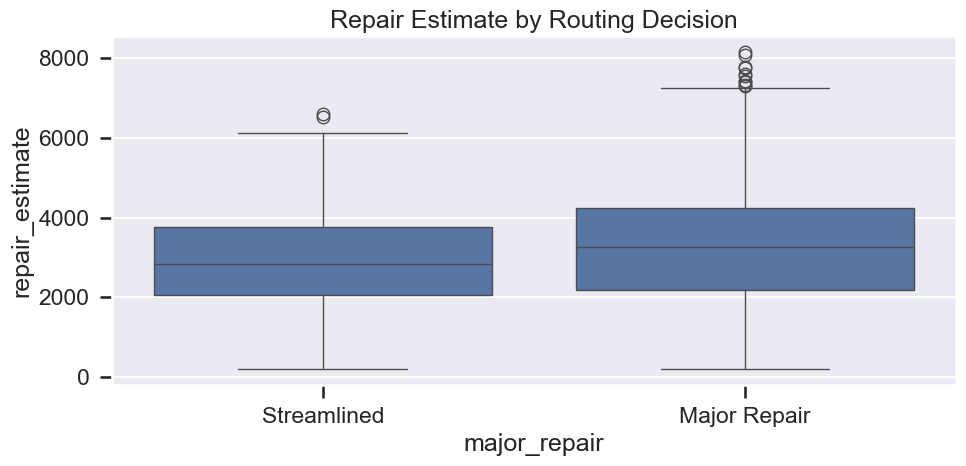

In [4]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="major_repair", y="repair_estimate")
plt.xticks([0, 1], ["Streamlined", "Major Repair"])
plt.title("Repair Estimate by Routing Decision")
plt.tight_layout()
plt.show()

## 3. Train LightGBM classifier

In [5]:
features = pd.get_dummies(df.drop(columns=["major_repair"]), drop_first=True)
target = df["major_repair"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=77, stratify=target
)

model = lgb.LGBMClassifier(
    random_state=77,
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1643, number of negative: 117
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1064
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.933523 -> initscore=2.642105
[LightGBM] [Info] Start training from score 2.642105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
              precision    recall  f1-score   support

           0       0.67      0.34      0.45        29
           1       0.96      0.99      0.97       411

    accuracy                           0.95       440
   macro avg       0.81      0.67      0.71       440
weighted avg       0.94      0.95      0.94       440

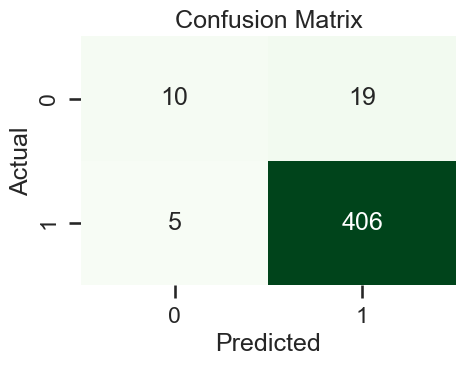

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_56031/2137712452.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='summer')


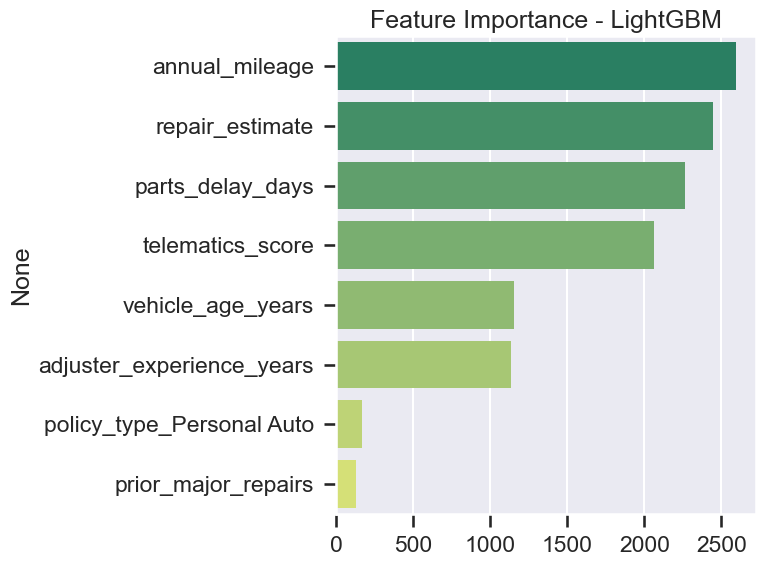

In [7]:
importance = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='summer')
plt.title('Feature Importance - LightGBM')
plt.tight_layout()
plt.show()